# Visualizing AQI during the 2017 Thomas Fire in Santa Barbara County

[Github Repository](https://github.com/jocardelle/thomas-fire-aqi)

## About

In this task I used [Air Quality Index (AQI)](https://www.airnow.gov/aqi/aqi-basics/) data from the [US Environmental Protection Agency](https://www.epa.gov) to visualize the impact on the AQI of the 2017 [Thomas Fire](https://en.wikipedia.org/wiki/Thomas_Fire) in Santa Barbara County. The Thomas Fire, which burned across Santa Barbara and Ventura counties in December 2017, has been one of California’s largest wildfires, devastating over 280,000 acres of land. The fire started on December 4, 2017 and was considered contained on January 2, 2018.

## Highlights
- Combining data frames
- Data wrangling with dates
- Visualizing time series
- Using `rolling()` to find a rolling average

## Datasets


## Load necessary packages

In [52]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt

## Read in data

I imported the data directly from the urls. The data imported contains daily AQI information by county in 2017 and 2018, respectively.

In [53]:
aqi_17 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip')
aqi_18 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip')

## Data exploration

In order to familiarize myself with the data I used various python functions. 

In [54]:
# Return first 5 rows of `aqi_17_head`
aqi_17_head = aqi_17.head()
aqi_17_head

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2017-01-01,28,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2017-01-04,29,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2017-01-10,25,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,1,3,2017-01-13,40,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,1,3,2017-01-16,22,Good,PM2.5,01-003-0010,1


In [55]:
# Return first 5 rows of `aqi_18_head`
aqi_18_head = aqi_18.head()
aqi_18_head

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2018-01-02,42,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2018-01-05,45,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2018-01-08,20,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,1,3,2018-01-11,25,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,1,3,2018-01-14,33,Good,PM2.5,01-003-0010,1


In [56]:
# Find shape of dataframes
print(aqi_17.shape)
print(aqi_18.shape)

(326801, 10)
(327541, 10)


In [57]:
# Find number of states
print(aqi_17['State Name'].nunique())
aqi_18['State Name'].nunique()

54


54

In [58]:
# Find unique states
print(aqi_17['State Name'].unique())
print(aqi_18['State Name'].unique())

['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Country Of Mexico' 'Delaware' 'District Of Columbia'
 'Florida' 'Georgia' 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas'
 'Kentucky' 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan'
 'Minnesota' 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada'
 'New Hampshire' 'New Jersey' 'New Mexico' 'New York' 'North Carolina'
 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Puerto Rico'
 'Rhode Island' 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah'
 'Vermont' 'Virgin Islands' 'Virginia' 'Washington' 'West Virginia'
 'Wisconsin' 'Wyoming']
['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Country Of Mexico' 'Delaware' 'District Of Columbia'
 'Florida' 'Georgia' 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas'
 'Kentucky' 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan'
 'Minnesota' 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Neva

Through my data exploration I first I viewed the first five rows of each data frame to familiarize myself with the contents of each column. I then found the size of each data frame; `aqi_17` has 326801 rows and 10 colums and `aqi_18` has 327541 rows and 10 columns. Next, I looked at the number of unique `State Name` in each data frame. Both had 54 states included. Since there are only 50 states, I next looked at the unique names for each state in the data frame. For both data frames the 4 extras are `Country of Mexico`, `District of Columbia`, `Puerto Rico`, and `Virgin Islands`.

## Combine data frames

The data frames are currently separate and I want them to be combined on top of each other. I achieved this using the `pandas` function `pd.concat()` and store the combined data frame as `aqi`.

In [59]:
aqi = pd.concat([aqi_17, aqi_18])

## Data cleaning

From my initial data exploration, I viewed that there were column names with capital letters and spaces. I tidied the data to lower snake case so all column names are in lower snake case.

In [60]:
# Initial column names
print(aqi.columns, '\n')

# Simplify column names
aqi.columns = (aqi.columns
                  .str.lower()
                  .str.replace(' ','_')
                )

# New column names
print(aqi.columns, '\n')

Index(['State Name', 'county Name', 'State Code', 'County Code', 'Date', 'AQI',
       'Category', 'Defining Parameter', 'Defining Site',
       'Number of Sites Reporting'],
      dtype='object') 

Index(['state_name', 'county_name', 'state_code', 'county_code', 'date', 'aqi',
       'category', 'defining_parameter', 'defining_site',
       'number_of_sites_reporting'],
      dtype='object') 



## Selecting data

I selected data of interest for this project which was from just `Santa Barbara` county. I then
removed the `state_name`, `county_name`, `state_code` and `county_code` columns to leave just the `date`, `aqi`, `category`, `defining_parameter`, `defining_stie`, and `number_of_sites_reporting` columns. 

In [61]:
# Create new variable with only Santa Barbara county info 
aqi_sb = aqi[aqi['county_name'] == 'Santa Barbara']

# Remove `state_name`, `county_name`, `state_code` and `county_code`
aqi_sb = aqi_sb.drop(['state_name', 'county_name', 'state_code', 'county_code'], axis=1)
aqi_sb

,date,aqi,category,defining_parameter,defining_site,number_of_sites_reporting
28648,2017-01-01,39,Good,Ozone,06-083-4003,12
28649,2017-01-02,39,Good,PM2.5,06-083-2011,11
28650,2017-01-03,71,Moderate,PM10,06-083-4003,12
28651,2017-01-04,34,Good,Ozone,06-083-4003,13
28652,2017-01-05,37,Good,Ozone,06-083-4003,12
...,...,...,...,...,...,...
29128,2018-12-27,37,Good,Ozone,06-083-1025,11
29129,2018-12-28,39,Good,Ozone,06-083-1021,12
29130,2018-12-29,39,Good,Ozone,06-083-1021,12
29131,2018-12-30,41,Good,PM2.5,06-083-1008,12


Next I wanted to ensure the `date` column is a `pandas.datetime` object. I also want the index of the dataset to be the date column.

In [62]:
# view current data type of date column
aqi_sb['date'].dtype

dtype('O')

In [63]:
# Update date column to pandas.datetime and set as index
aqi_sb['date'] = pd.to_datetime(aqi_sb['date'])
aqi_sb = aqi_sb.set_index('date')

In [64]:
# confirm date column is index
aqi_sb.head()

,aqi,category,defining_parameter,defining_site,number_of_sites_reporting
date,,,,,
2017-01-01,39,Good,Ozone,06-083-4003,12
2017-01-02,39,Good,PM2.5,06-083-2011,11
2017-01-03,71,Moderate,PM10,06-083-4003,12
2017-01-04,34,Good,Ozone,06-083-4003,13
2017-01-05,37,Good,Ozone,06-083-4003,12


## Data wrangling

Next, I calculated a rolling average of the AQI over a 5 day period using the `rolling()`method for `pandas.Series`. I added it as a new column to the `aqi_sb` data frame.

In [66]:
aqi_sb['five_day_average'] = aqi_sb['aqi'].rolling('5D').mean()
aqi_sb.head()

,aqi,category,defining_parameter,defining_site,number_of_sites_reporting,five_day_average
date,,,,,,
2017-01-01,39,Good,Ozone,06-083-4003,12,39.000000
2017-01-02,39,Good,PM2.5,06-083-2011,11,39.000000
2017-01-03,71,Moderate,PM10,06-083-4003,12,49.666667
2017-01-04,34,Good,Ozone,06-083-4003,13,45.750000
2017-01-05,37,Good,Ozone,06-083-4003,12,44.000000


## Plot the data

In order to view the effects of the Thomas Fire on AQI I made a line plot showing both the daily AQI and the 5-day average (5-day average on top of the AQI) using `matplotlib`.

<Axes: title={'center': 'Daily AQI vs. 5 Day Average in Santa Barbara County'}, xlabel='Date', ylabel='AQI'>

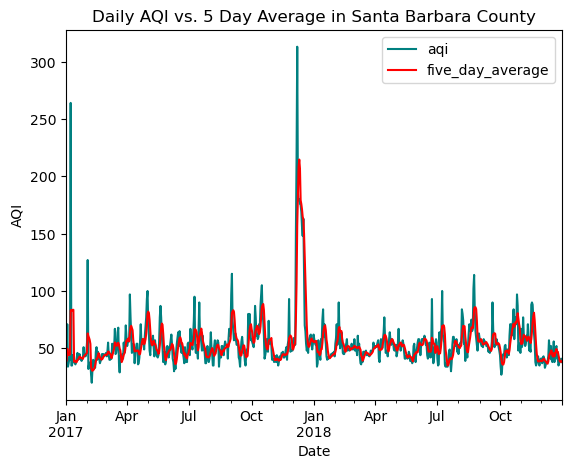

In [68]:
aqi_sb.plot(y=['aqi', 'five_day_average'],
        title = 'Daily AQI vs. 5 Day Average in Santa Barbara County',
        xlabel='Date',
        ylabel='AQI',        
        color = {'aqi':'#008080',
                 'five_day_average': '#FF0000'
                 }
        )

From this graph, we can view a sharp spike in AQI in Santa Barbara County in December 2017. This is the same time when the Thomas Fire occured